# Claim Probability Modeling

**Objective:** Build and evaluate classification models to predict the probability that a policy will have a claim (`HadClaim`).

- **Target:** `HadClaim` (Boolean)
- **Evaluation Metrics:**  
  - **Accuracy**  
  - **Precision**  
  - **Recall**  
  - **F1-score**  
  - **ROC–AUC**

**Outline:**
1. Imports  
2. Load & Clean Data  
3. Define X, y  
4. Feature Engineering (same pipeline)  
5. Train/Test Split  
6. Train Classification Models  
7. Evaluate & Compare Models  
8. Plot ROC Curves & Confusion Matrices  
9. Interpret Results (including SHAP summary)  
10. Save Best Model  


In [1]:
import pandas as pd
import os 
import sys
sys.path.append(os.path.abspath('../../src'))
from models import split_data, train_classification_models, evaluate_classification_model, plot_shap_summary
from Data_Processing import load_and_clean_data, encode_categoricals, scale_and_transform
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [2]:
# load and clean the data
df = load_and_clean_data("../../Data/cleaned_data_for_StatisticalAnalysis.csv")
df.drop(columns=["PostalCode","mmcode"], inplace=True)
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")


c:\Users\adoni\Desktop\KAIM COURSE\WEEK-3\InsuranceRiskAnalysisAndPredictiveModeling\src\Data_Processing.py:17: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


✅ Data loaded: 618319 rows, 22 columns


In [3]:
# segment the data into training and testing sets
y = df['HadClaim'].astype(int)
X = df.drop(columns=['HadClaim', 'TotalClaims', 'Margin', 'LossRatio',"PolicyID","UnderwrittenCoverID"])  # drop severity targets
print(f"▶️ Features shape: {X.shape}, Target distribution:\n{y.value_counts(normalize=True)}")


▶️ Features shape: (618319, 16), Target distribution:
HadClaim
0    0.995491
1    0.004509
Name: proportion, dtype: float64


In [4]:
# Date & vehicle age
X['TransactionMonth'] = pd.to_datetime(X['TransactionMonth'])
X['Month'] = X['TransactionMonth'].dt.month
X['VehicleAge'] = X['TransactionMonth'].dt.year - X['RegistrationYear']
X = X.drop(columns=['TransactionMonth', 'RegistrationYear'])

# Encode & Scale
X_enc = encode_categoricals(X)
X_prepared = scale_and_transform(X_enc)
print(f"⚙️ Prepared features: {X_prepared.shape[1]} columns")


⚙️ Prepared features: 62 columns


In [5]:
X_prepared.columns

Index(['IsVATRegistered', 'Cylinders', 'cubiccapacity', 'kilowatts',
       'NumberOfDoors', 'SumInsured', 'CalculatedPremiumPerTerm',
       'TotalPremium', 'Month', 'VehicleAge', 'Province_Free State',
       'Province_Gauteng', 'Province_KwaZulu-Natal', 'Province_Limpopo',
       'Province_Mpumalanga', 'Province_North West', 'Province_Northern Cape',
       'Province_Western Cape', 'MainCrestaZone_Cape Province (Cape Town)',
       'MainCrestaZone_Cape Province (East and North of Cape Town)',
       'MainCrestaZone_Ciskei, Cape Mid 1', 'MainCrestaZone_East London',
       'MainCrestaZone_Johannesburg',
       'MainCrestaZone_Karoo 1 (Northeast of Cape Town)',
       'MainCrestaZone_Langkloof, Coast 2, Coast 1', 'MainCrestaZone_Natal',
       'MainCrestaZone_Natal (Durban)', 'MainCrestaZone_Oranje Free State',
       'MainCrestaZone_Port Elizabeth', 'MainCrestaZone_Rand East',
       'MainCrestaZone_Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1',
       'MainCrestaZone_Transvaal (Preto

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = split_data(X_prepared, y)
print(f"🔨 Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")

🔨 Training on 494655 samples, testing on 123664 samples


In [7]:
# Train classification models
classification_models = train_classification_models(X_train, y_train)
print("✅ Trained classification models:", list(classification_models.keys()))


C:\Users\adoni\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Trained classification models: ['LogisticRegression', 'DecisionTree', 'RandomForest']


In [8]:
# Evaluate models
results = {}
for name, model in classification_models.items():
    acc, prec, rec, f1, roc_auc, y_pred, y_proba = evaluate_classification_model(model, X_test, y_test)
    results[name] = dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=roc_auc)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC–AUC: {roc_auc:.3f}\n")


--- LogisticRegression ---
Accuracy: 0.995, Precision: 0.833, Recall: 0.009, F1: 0.017, ROC–AUC: 0.882

--- DecisionTree ---
Accuracy: 0.993, Precision: 0.118, Recall: 0.071, F1: 0.088, ROC–AUC: 0.589

--- RandomForest ---
Accuracy: 0.995, Precision: 0.285, Recall: 0.062, F1: 0.101, ROC–AUC: 0.651



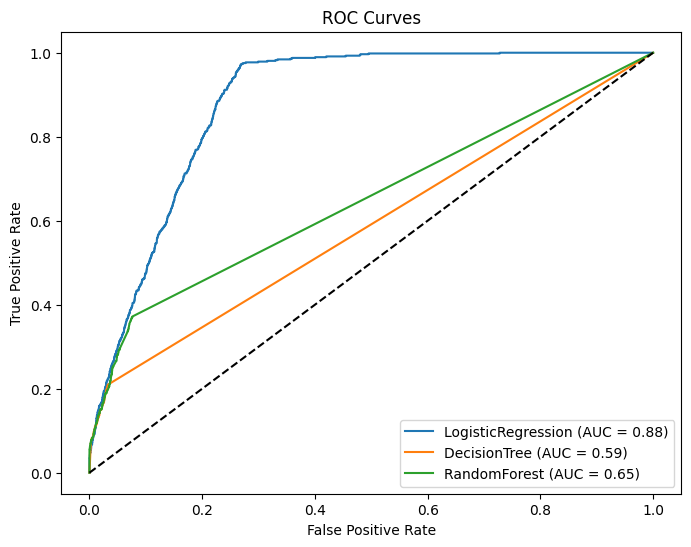

In [9]:
# ROC Curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))
for name, model in classification_models.items():
    if hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


LogisticRegression seems to be doing better

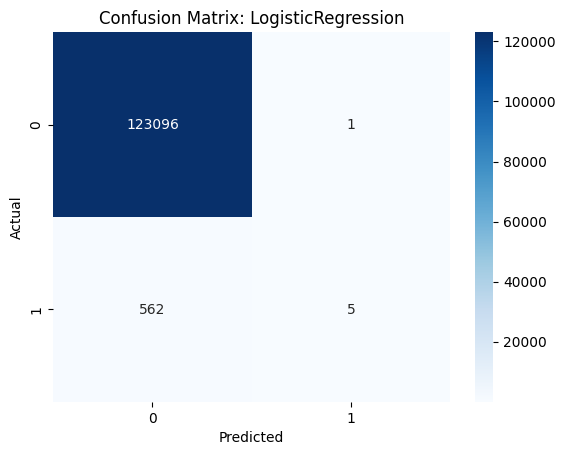

In [10]:
# Confusion Matrix for best model
from sklearn.metrics import confusion_matrix
best_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = classification_models[best_name]
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


🔎 Interpreting best model: LogisticRegression


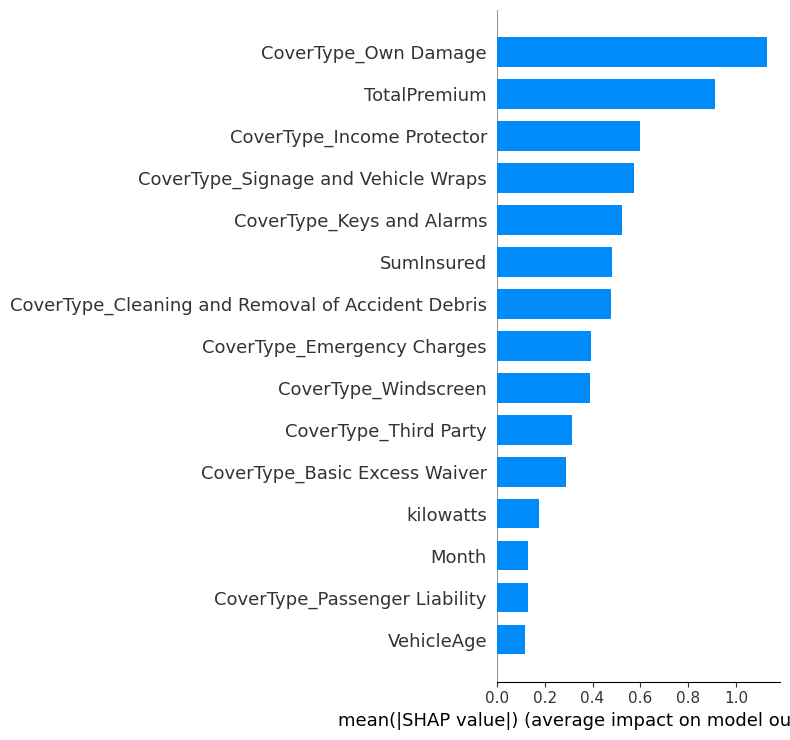

In [ ]:
# Interpret best model using SHAP
print(f"🔎 Interpreting best model: {best_name}")
plot_shap_summary(best_model, X_test)


In [15]:
# save the best model
joblib.dump(best_model, "../../Models/claim_Probability.joblib")

['../../Models/claim_Probability.joblib']

#### Feature Importance (Logistic Regression) via SHAP

The SHAP summary bar plot highlights the top features influencing the model’s predicted probability of a claim:

- **CoverType_Own Damage** (highest mean |SHAP value|): Policies with “Own Damage” coverage see the largest shift in predicted claim probability.
- **TotalPremium**: Higher premiums correlate with higher claim probability—reflecting that more expensive policies tend to file more claims.
- **CoverType_Income Protector**, **CoverType_Signage and Vehicle Wraps**, **CoverType_Keys and Alarms**, **SumInsured**: Various coverages and insured values meaningfully affect claim likelihood.
- **CoverType_Cleaning and Removal of Accident Debris**, **CoverType_Emergency Charges**, **CoverType_Windscreen**, **CoverType_Third Party**, **CoverType_Basic Excess Waiver**: Even niche cover categories impact the probability.
- **Vehicle Characteristics** (`kilowatts`) and **Temporal Feature** (`Month`) appear lower but still contribute.
- **VehicleAge** also shows up, indicating older vehicles slightly increase claim likelihood.

> **Key Takeaways:**  
> - **Cover type** is the dominant driver of claim probability—underwriting should weigh coverage mix heavily.  
> - **Premium amount** and **sum insured** naturally align with risk.  
> - Operationally, we might offer targeted interventions (e.g., premium discounts or risk advisories) for policies lacking “Own Damage” but with other high‑impact covers.
